In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data

%matplotlib inline


In [144]:
# Import data
data = pd.read_excel("support_files/OSEBX.xlsx")

In [145]:
data.head()

OSEBX    Last    High     Low  Official turnover (NOK)
0 2018-11-14     NaN     NaN     NaN             3.790000e+02
1 2018-11-13  875.43  887.95  875.17             5.126725e+09
2 2018-11-12  886.62  892.64  885.44             3.591581e+09
3 2018-11-09  886.44  892.58  884.16             4.405451e+09
4 2018-11-08  892.49  900.74  891.50             4.463838e+09

In [146]:
data.rename(columns={'OSEBX' : 'Date', 'Official turnover (NOK)' : 'Volume'}, inplace=True)

In [147]:
data['Date'] = pd.to_datetime(data['Date'])

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5743 entries, 0 to 5742
Data columns (total 5 columns):
Date      5743 non-null datetime64[ns]
Last      5742 non-null float64
High      4390 non-null float64
Low       4390 non-null float64
Volume    5624 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 224.4 KB


In [149]:
data['Direction'] = data.Last.diff().shift()

In [150]:
data['Direction'] = data.Direction.apply(lambda x: 1 if x > 0 else 0)

In [151]:
data['Close'] = data.Last.shift()
data.drop('Last', axis=1, inplace=True)

In [152]:
data.set_value(1, 'Close', 876.30)
data.set_value(0, 'Close', 872.10);

C:\anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\anaconda\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


In [153]:
# Reorder columns
data = data[['Date', 'High', 'Low', 'Close', 'Volume', 'Direction']].copy()

In [154]:
# Sort the timeseries correctly with last observation on the last row (important for technical features)
data = data.sort_values(by='Date', ascending=True);

In [155]:
# Moving average indicators, short, medium and long term
data['SMA10'] = data.Close.rolling(10).mean()
data['SMA30'] = data.Close.rolling(30).mean()
data['SMA90'] = data.Close.rolling(90).mean()

In [156]:
# Exponential moving average 
data['EWA10'] = data['Close'].ewm(span=10, min_periods=10).mean()
data['EWA30'] = data['Close'].ewm(span=30, min_periods=30).mean()
data['EWA90'] = data['Close'].ewm(span=90, min_periods=90).mean()

In [157]:
# Stochastic Osciallator
data['SOI'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])

In [158]:
# 10, 5 and 2 Day Momentum
data['Momentum_10'] = data['Close'].diff(10)
data['Momentum_5'] = data['Close'].diff(5)
data['Momentum_2'] = data['Close'].diff(2)

In [159]:
data['STD'] = data['Close'].rolling(20, min_periods=20).std()

In [160]:
data['Day'] = data.Date.dt.dayofweek

In [161]:
data['Day'].replace({0: 'Monday', 1 : 'Tuesday', 2: 'Wednesday', 3 : 'Thursday', 4 : 'Friday'}, inplace=True);

In [162]:
data.Day.value_counts()

Tuesday      1172
Wednesday    1171
Friday       1149
Monday       1126
Thursday     1125
Name: Day, dtype: int64

In [163]:
data = pd.get_dummies(data);

In [164]:
data.reset_index(drop=True, inplace=True);

In [165]:
def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    
    return df

In [166]:
data = relative_strength_index(data, 14)

In [167]:
data.isnull().sum()

Date                0
High             1353
Low              1353
Close               0
Volume            119
Direction           0
SMA10               9
SMA30              29
SMA90              89
EWA10               9
EWA30              29
EWA90              89
SOI              1353
Momentum_10        10
Momentum_5          5
Momentum_2          2
STD                19
Day_Friday          0
Day_Monday          0
Day_Thursday        0
Day_Tuesday         0
Day_Wednesday       0
RSI_14           1352
dtype: int64

In [168]:
data.tail()

Date    High     Low   Close        Volume  Direction    SMA10  \
5738 2018-11-08  900.74  891.50  886.44  4.463838e+09          0  886.731   
5739 2018-11-09  892.58  884.16  886.62  4.405451e+09          1  887.815   
5740 2018-11-12  892.64  885.44  875.43  3.591581e+09          0  888.473   
5741 2018-11-13  887.95  875.17  876.30  5.126725e+09          0  887.137   
5742 2018-11-14     NaN     NaN  872.10  3.790000e+02          0  885.851   

           SMA30       SMA90       EWA10    ...     Momentum_10  Momentum_5  \
5738  897.993333  899.857444  888.206148    ...           23.64       -2.58   
5739  896.143667  899.834778  887.917757    ...           10.84       -6.97   
5740  893.839333  899.571444  885.647256    ...            6.58      -15.48   
5741  891.706000  899.407667  883.947755    ...          -13.36      -19.31   
5742  889.777667  899.264444  881.793618    ...          -12.86      -20.39   

      Momentum_2        STD  Day_Friday  Day_Monday  Day_Thursday  \
5738       -9.17  12.630985           0           0             1   
5739       -5.87  12.487752           1           0             0   
5740      -11.01  11.813649           0           1             0   
5741      -10.32  10.976545           0           0             0   
5742       -3.33  11.038384           0           0             0   

      Day_Tuesday  Day_Wednesday    RSI_14  
5738            0              0  0.637307  
5739            0              0  0.501824  
5740            0              0  0.502821  
5741            1              0  0.360389  
5742            0              1  0.360389  

[5 rows x 23 columns]

In [169]:
data.dropna(inplace=True)

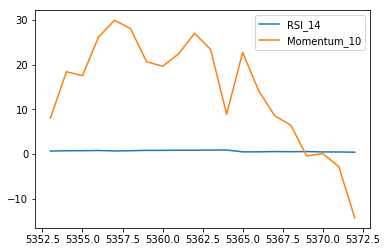

In [170]:
# Visualize sanity check
data.iloc[4000:4020].plot( y=['RSI_14', 'Momentum_10']);

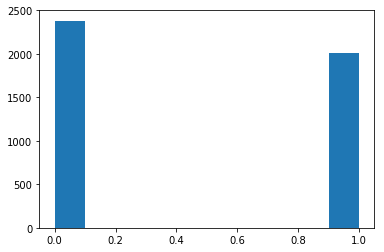

In [171]:
plt.hist(data.Direction);
plt.xlim();
        

In [172]:
# data.reset_index(drop=True, inplace=True)

In [173]:
# Set index to Date
data.set_index('Date', inplace=True)

In [174]:
data.replace(-np.inf, np.nan, inplace=True)

In [175]:
data.fillna(method='ffill', inplace=True)

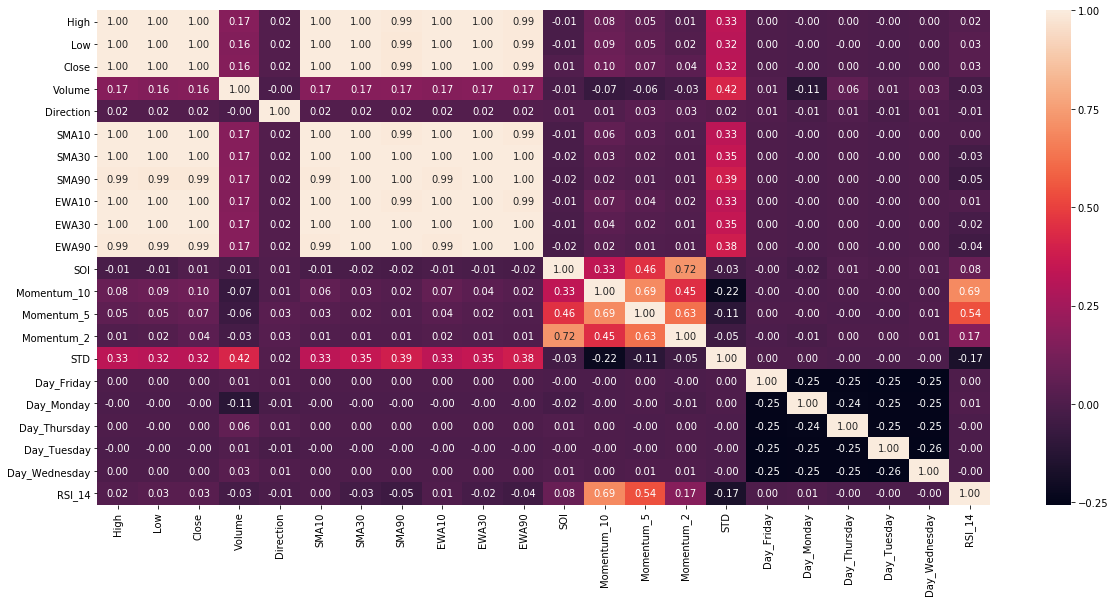

In [176]:
fig, ax = plt.subplots(figsize=(20,20))
plt.subplot(2,1,1)
sns.heatmap(data.corr(), annot=True, fmt='.2f');

In [177]:
# Split to target and features
target = data.Direction
features = data.drop(["Direction"], axis=1)

In [178]:
# Normalize the data
norm = Normalizer()
features = norm.fit_transform(features)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

In [180]:
features.shape

(4388, 21)

In [181]:
features_numpy = data.drop(["Direction"], axis=1).values
target_numpy = data.Direction.values

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(features_numpy, target_numpy, test_size=0.30, random_state=42)


In [94]:
clf = SVC(probability=True)

param_dist_svm = {
 'kernel': ['linear', 'rbf', 'poly'],
 'C' : [0.001,0.05,0.1]

 }

svmmodel = GridSearchCV(clf, param_grid=param_dist_svm )
svmmodel.fit(X_train, y_train);


In [95]:
y_pred = svmmodel.predict_proba(X_test)


In [96]:
def roc_scores (y_predict, y_test=y_test):
    
    # Compute for probabilities for positive outcome
    fpr, tpr, tresholds = roc_curve(y_test, y_predict[:,1])
    roc_auc = roc_auc_score(y_test, y_predict[:,1])

    return fpr, tpr, tresholds, roc_auc

def plot_roc(fpr, tpr, roc_auc, title="ROC"):
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right");

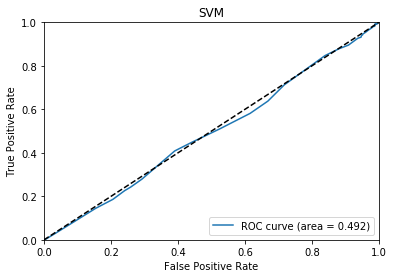

In [97]:
fpr, tpr, tresholds, roc_auc = roc_scores(y_pred)
plot_roc(fpr,tpr,roc_auc, 'SVM')

In [98]:
lr = LogisticRegression()

In [99]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [100]:
y_perd_lr = lr.predict_proba(X_test)

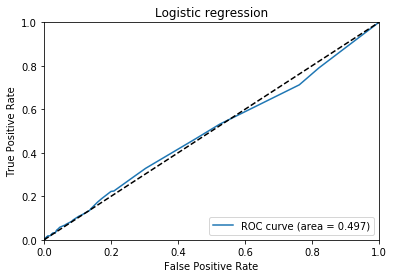

In [101]:
fpr, tpr, tresholds, roc_auc = roc_scores(y_perd_lr)
plot_roc(fpr,tpr,roc_auc, 'Logistic regression')

In [102]:
rf = RandomForestClassifier()

# specify parameters and distributions to sample from
param_dist1 = {"max_depth": [5,10,15,20],
              "n_estimators" : [100, 1000, 10000],
              "min_samples_split": [3,5,10,15,20],
              "bootstrap": [True, False],
              "min_samples_leaf" : [3,5,10,15,20]
                            }
n_iter_search = 20
randommodel = RandomizedSearchCV(rf, param_distributions=param_dist1,
                                   n_iter=n_iter_search, cv=5, verbose=10, n_jobs=-1)
randommodel.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.3min remaining:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


In [103]:
rf_pred = randommodel.predict_proba(X_test)

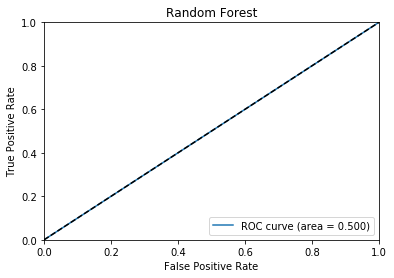

In [104]:
fpr, tpr, tresholds, roc_auc = roc_scores(rf_pred)
plot_roc(fpr,tpr,roc_auc, 'Random Forest')

## Recurrent neural network

In [299]:
# Data from numpy
featuresTrain = torch.from_numpy(X_train_np).float()
targetsTrain = torch.from_numpy(y_train_np).float()

featuresTest = torch.from_numpy(X_test_np).float()
targetsTest = torch.from_numpy(y_test_np).float()

In [300]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# Data loader
trainloader = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = False)
testloader = torch.utils.data.DataLoader(test, batch_size = 32, shuffle = False)

In [295]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size

        self.inp = nn.Linear(21, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 2, dropout=0.05)
        self.out = nn.Linear(hidden_size, 1)

    def step(self, input, hidden=None):
        input = self.inp(input.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden

    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            if force or i == 0:
                input = inputs[i]
            else:
                input = output
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden
    


In [287]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, 2, dropout=0.05)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

In [342]:
def check_perfomance(loader, model, criterion, device, optimizer):
    """
    Validation function, takes dataloader, model, criterion, device and optimizer as 
    arguments and returns test_loss and accuracy
    """
    test_loss = 0
    accuracy = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    total = 0
    correct = 0
    model.eval()
    # Loop over images and labels in dataloader
    for features, labels in loader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
       
        # Calculate loss
        output = model.forward(features)

        # Get predictions from the maximum value
        predicted = torch.max(output[0].data, 1)[1]
        predicted = predicted.float()

        # Total number of labels
        total += labels.size(0)

        correct += (predicted == labels).sum()

        accuracy = 100 * correct / float(total)
        test_loss += criterion(torch.squeeze(output[0]), labels).item()
        
    return test_loss, accuracy

In [349]:
def train_model(optimizer, criterion, model, epochs=2):
#     device = torch.device("cuda:0" if torch.cuda.is_available else 'cpu')
    device = 'cpu'
    model.to(device)
    print_every = 5
    steps = 0
    print_every = 10
    running_loss = 0
    

    for epoch in range(n_epochs):
        model.train()

        for features, label in trainloader:
            
            features.to(device)
            label.to(device)
            
            optimizer.zero_grad()
            
            output = model.forward(features)
            
            loss = criterion(torch.squeeze(output[0]), label)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if steps % print_every == 0:
                model.eval()
                test_loss = 0
                accuracy = 0
                optimizer.zero_grad()          
                with torch.no_grad():
                                                          
                    test_loss, accuracy = check_perfomance(testloader, model, criterion, device, optimizer)
                                
                print("Epoch: {}/{}... ".format(epoch+1, n_epochs),
                      "Loss: {:.4f}".format(running_loss/print_every),
                      "Device : {}..".format(device),
                      "Test_loss : {}..".format(test_loss/len(testloader)),
                      "Test_Accuracy : {}..".format(accuracy/len(testloader)))
                             
                running_loss = 0
            model.train()
            
    return model


In [350]:
hidden_size = 100
model = SimpleRNN(hidden_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

final_model = train_model(optimizer, criterion, model)



Epoch: 1/100...  Loss: 0.0485 Device : cpu.. Test_loss : 0.48838878458454493.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0385 Device : cpu.. Test_loss : 0.4639015800896145.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0660 Device : cpu.. Test_loss : 0.4268368411631811.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0302 Device : cpu.. Test_loss : 0.41149053296872545.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0529 Device : cpu.. Test_loss : 0.38468930018799646.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0542 Device : cpu.. Test_loss : 0.3592311360296749.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0333 Device : cpu.. Test_loss : 0.3470222329099973.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0296 Device : cpu.. Test_loss : 0.3366978274924414.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0382 Device : cpu.. Test_loss : 0.32336795046215966.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0371 Device : cpu.. Test_loss : 0.31207977838459466.. Test_Accuracy : 42..
Epoch

Epoch: 1/100...  Loss: 0.0266 Device : cpu.. Test_loss : 0.24747742215792337.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0259 Device : cpu.. Test_loss : 0.2479254596290134.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0249 Device : cpu.. Test_loss : 0.2474343404173851.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0248 Device : cpu.. Test_loss : 0.24688542456853957.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0257 Device : cpu.. Test_loss : 0.24709093286877587.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0265 Device : cpu.. Test_loss : 0.2477467819338753.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0246 Device : cpu.. Test_loss : 0.24772473247278304.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0237 Device : cpu.. Test_loss : 0.2469130286148616.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0234 Device : cpu.. Test_loss : 0.24668515828393756.. Test_Accuracy : 42..
Epoch: 1/100...  Loss: 0.0246 Device : cpu.. Test_loss : 0.24662496539808454.. Test_Accuracy : 42..
Epoc

Epoch: 2/100...  Loss: 0.0248 Device : cpu.. Test_loss : 0.24861694020884378.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0254 Device : cpu.. Test_loss : 0.24940165451594762.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0242 Device : cpu.. Test_loss : 0.2488502100819633.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0251 Device : cpu.. Test_loss : 0.2496410927602223.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0251 Device : cpu.. Test_loss : 0.249201238155365.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0250 Device : cpu.. Test_loss : 0.24770250171422958.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0250 Device : cpu.. Test_loss : 0.24752671058688844.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0253 Device : cpu.. Test_loss : 0.24761017234552474.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0260 Device : cpu.. Test_loss : 0.24755226217565082.. Test_Accuracy : 42..
Epoch: 2/100...  Loss: 0.0241 Device : cpu.. Test_loss : 0.24720228108621778.. Test_Accuracy : 42..
Epoc

KeyboardInterrupt: 